## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

1. **Critical Care Protocols:** "What is the protocol for managing sepsis in a critical care unit?"

2. **General Surgery:** "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

3. **Dermatology:** "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

4. **Neurology:** "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [1]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              datasets==4.0.0 \
              evaluate==0.4.5 \
              langchain_openai==0.3.30 \
              opentelemetry-api==1.37.0 opentelemetry-sdk==1.37.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 116.9 MB/s eta 0:00:00

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

###Importing Necessary Libararies

In [1]:
# Import core libraries
import os                                                                       # Interact with the operating system (e.g., set environment variables)
import json                                                                     # Read/write JSON data
import requests  # type: ignore                                                 # Make HTTP requests (e.g., API calls); ignore type checker

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader                            # Load and extract text from PDF files
# from langchain_community.document_loaders import PyPDFLoader                    # Load and extract text from PDF files
from openai import OpenAI                                                       # Access OpenAI's models and services

# Import libraries for processing dataframes and text
import tiktoken                                                                 # Tokenizer used for counting and splitting text for models
import pandas as pd                                                             # Load, manipulate, and analyze tabular data

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter              # Break text into overlapping chunks for processing
from langchain_openai import OpenAIEmbeddings                                   # Create vector embeddings using OpenAI's models  # type: ignore
from langchain.vectorstores import Chroma                                       # Store and search vector embeddings using Chroma DB  # type: ignore

from datasets import Dataset                                                    # Used to structure the input (questions, answers, contexts etc.) in tabular format
from langchain_openai import ChatOpenAI                                         # This is needed since LLM is used in metric computation

## **Question Answering using LLM**

> **Note 1:** When choosing between an open-source Hugging Face (HF) model and OpenAI’s proprietary model, base your decision on your specific needs. If you opt for a Hugging Face model, make sure to connect to a GPU to execute the code efficiently.

> **Note 2**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:
1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.
2. Switch to a different Google account and resume working on the project from there.
3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

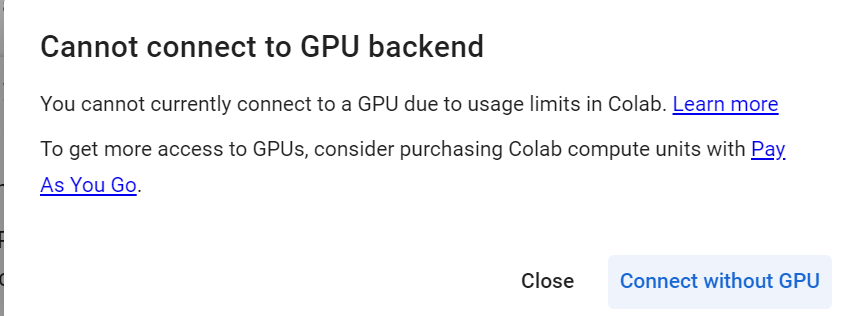

### **Calling the OpenAI API**

In [2]:
#Loading the OpenAI API key and Base from the colab secrets
from google.colab import userdata
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
OPENAI_API_BASE=userdata.get('OPENAI_API_BASE')

#Storing API credentials (api key and api base) in environment variables
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE

# Initialize the OpenAI client
client = OpenAI()

### **Defining a function to Get Respnse from the LLM Model**

In [3]:
# Define a function to get a response
def response(user_prompt, max_tokens=500, temperature=0.3, top_p=0.95):
    # Create a chat completion using the OpenAI client, we are using gpt-4o-mini model
    # and temp=0.3 means more deterministic output, with top 95% responses
    # user_prompt will be the Query asked to the Medical Assistant
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p
    )
    #returning the content of first retrieved message
    return completion.choices[0].message.content

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [4]:
# Defining question1
question_1 = "What is the procedure for managing sepsis in a critical care unit?"

In [ ]:
#getting response for question_1 from our LLM Model
base_prompt_response_1 = response(question_1)
base_prompt_response_1

"Managing sepsis in a critical care unit involves a systematic approach that includes early recognition, prompt intervention, and ongoing monitoring. Here’s a general outline of the procedure for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Identify Symptoms:** Look for signs of infection (fever, chills, tachycardia, tachypnea) and organ dysfunction (altered mental status, hypotension, elevated lactate).\n   - **Use Screening Tools:** Utilize screening tools like the SOFA (Sequential Organ Failure Assessment) score or qSOFA (quick SOFA) to assess the severity of sepsis.\n\n### 2. **Initial Assessment**\n   - **Vital Signs Monitoring:** Continuous monitoring of heart rate, blood pressure, respiratory rate, and temperature.\n   - **Laboratory Tests:** Obtain blood cultures before starting antibiotics, and perform complete blood count, liver and renal function tests, and lactate levels.\n   - **Imaging Studies:** If indicated, perform imaging studies to identify the source of 



*   The observation is that the response answers the asked question regarding sepsis by relying on the training of GPT-4o-mini
*   The response lists the step-by-step procedure for sepsis treatment. However, the response could not get completed in 500 tokens. Is seems that there is some additional text after 500 tokens. However, in emergency it could be take significant time to understand and take actions for critical conditions like sepsis.
*   The long-answer is not suited for emergency handling sitautions like sepsis to save the patient.



### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [8]:
# Defining question2
question_2 = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

In [ ]:
#Getting response for question_2 from our LLM
base_prompt_response_2 = response(question_2)
base_prompt_response_2

'Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then moves to the lower right abdomen.\n2. **Loss of Appetite**: A sudden decrease in appetite is common.\n3. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n4. **Fever**: A low-grade fever may develop.\n5. **Constipation or Diarrhea**: Changes in bowel habits can occur.\n6. **Abdominal Swelling**: In some cases, the abdomen may become swollen.\n\nAppendicitis cannot be treated effectively with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, a procedure known as an **appendectomy**. There are two main types of appendectomy:\n\n1. **Open Appendectomy**: A larger incision is made in the lower right abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: This is a minimally invasive procedure where several small incisions are made, and the appendix is removed with the aid of a camera and specialized instrum



*   The observation is that the response is good and aptly answers the question regarding symptoms and treatment of appendicitis.
*   The response is defined with token limit of 500 tokens.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [12]:
# Defining question3
question_3="What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

In [ ]:
#Getting response to question_3 from our LLM
base_prompt_response_3 = response(question_3)
base_prompt_response_3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp and other areas of the body. Here are some effective treatments and solutions, as well as potential causes for this condition:\n\n### Possible Causes\n1. **Autoimmune Disorders**: Alopecia areata is an autoimmune condition where the immune system mistakenly attacks hair follicles.\n2. **Genetics**: A family history of alopecia or other autoimmune diseases may increase the risk.\n3. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n4. **Hormonal Changes**: Changes in hormones, such as those occurring during pregnancy or menopause, can contribute to hair loss.\n5. **Nutritional Deficiencies**: Lack of essential nutrients, such as iron, zinc, or vitamin D, can affect hair health.\n6. **Infections**: Fungal infections of the scalp can lead to hair loss.\n7. **Thyroid Disorders**: Conditions affecting the thyroid can also lead to hair loss.\n\n



*   The observation is that the GPT-4o-mini model answers the asked question form medical domain.
*   The response contains 7 causes and 9 treatments for patchy baldness.
*   However, the response seems longer than 500 words is truncated at 500 token limit.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [14]:
# Defining question4
question_4="What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


In [ ]:
#Getting response for question_4 from our LLM
base_prompt_response_4 = response(question_4)
base_prompt_response_4

'The treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment:\n\n1. **Emergency Care**: \n   - Initial treatment may involve emergency medical care to stabilize the patient, which can include ensuring adequate oxygen supply, managing blood pressure, and preventing further injury.\n\n2. **Surgery**: \n   - In cases of severe injury, surgical intervention may be necessary to remove blood clots (hematomas), repair skull fractures, or relieve pressure on the brain.\n\n3. **Medication**: \n   - Medications may be prescribed to manage symptoms such as pain, seizures, or swelling. Corticosteroids may be used to reduce inflammation, and other medications may help with mood stabilization or cognitive function.\n\n4. **Rehabilitation**: \n   - **Physical Therapy**:



*   The response answers the possible treatements for brain injury from a trauma. However, perament impairment of brain function is not answered.
*   The response was long longer than 500 tokens, which is stopped at max_token limit.
*   The response is generic suggesting 9 treatments including, rehabilitation, medication, psychological support etc. and lacks detailed medical procedures or surgeries from a neurosurgeon/ neuro-specialist point-of-view.



### **Storing the Q/A Results of Base Prompting**

In [17]:
# Create the DataFrame
result_df = pd.DataFrame({
    "questions": [question_1, question_2, question_3, question_4],
    "base_prompt_responses": [base_prompt_response_1, base_prompt_response_2, base_prompt_response_3,base_prompt_response_4]})

# Display the DataFrame
result_df.head()

,questions,base_prompt_responses
0,What is the procedure for managing sepsis in a...,Managing sepsis in a critical care unit involv...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ..."
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...


## **Question Answering using LLM with Prompt Engineering**

## **Prompt Engineering Combination 1**
Here, we try prompt engineering by parameter tuning for our LLM response. Specifially, we are setting a **higher temperature=0.8**, top_p=0.95, and max_tokens=500

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [ ]:
#Getting response to question_1 from our LLM by parameter tuning for Combination 1
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.95
prompt_engg_comb1_res1 = response(question_1, max_tokens=500, temperature=0.8, top_p=0.95)
prompt_engg_comb1_res1

'Managing sepsis in a critical care unit involves a systematic approach that includes early recognition, prompt treatment, and ongoing monitoring. The following steps outline a general procedure for managing sepsis:\n\n### 1. **Early Recognition:**\n   - **Identify Symptoms:** Look for signs of sepsis such as fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension.\n   - **Use Screening Tools:** Utilize sepsis screening tools such as the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk.\n\n### 2. **Initial Assessment:**\n   - **Obtain History and Perform Physical Exam:** Gather information about the patient’s medical history, recent infections, and current medications.\n   - **Vital Signs Monitoring:** Continuously monitor vital signs, including blood pressure, heart rate, respiratory rate, and temperature.\n\n### 3. **Immediate Interventions:**\n   - **Fluid Resuscitation:** Administer intravenous fluids



*   The observation is that even with high temperature, the LLM model answered the question to manage sepsis. However, the LLM introduced creativity or randomness by using simple english language words, while forming the response.
*   This shows the power of GPT-4o-mini to handle questions from diverse fields, including medical domain
*   The response is long and 500 tokens could not provide a complete response to the question. Long answers for critical medical questions are not recommended.



### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [ ]:
#Getting response to question_2 from our LLM by parameter tuning for Combination 1
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.95
prompt_engg_comb1_res2 = response(question_2, max_tokens=500, temperature=0.8, top_p=0.95)
prompt_engg_comb1_res2

'Common symptoms of appendicitis typically include:\n\n1. **Abdominal Pain**: This often starts around the navel and then shifts to the lower right abdomen.\n2. **Nausea and Vomiting**: These symptoms usually accompany the abdominal pain.\n3. **Loss of Appetite**: Many people experience a decreased desire to eat.\n4. **Fever**: A low-grade fever may occur.\n5. **Constipation or Diarrhea**: Some individuals may experience changes in bowel habits.\n6. **Abdominal Swelling**: In some cases, the abdomen may appear swollen.\n\nAppendicitis generally cannot be treated effectively with medication alone. The primary treatment for appendicitis is surgical removal of the appendix, known as **appendectomy**. This procedure can be performed using two methods:\n\n1. **Open Appendectomy**: A larger incision is made in the abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: This minimally invasive technique involves smaller incisions and the use of a camera to guide the surgery.\n\nIn 



*   The observation is that the GPT-4o-mini LLM does a good job in answering symptoms and surgical treatments for appendicitis.
*   Though, with high temperature, the response is as good as with low temperature, because the medical domain data has less space for creativity than language literatures.
*   The response is defined within the token limit of 500.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [ ]:
#Getting response to question_3 from our LLM by parameter tuning for Combination 1
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.95
prompt_engg_comb1_res3 = response(question_3, max_tokens=500, temperature=0.8, top_p=0.95)
prompt_engg_comb1_res3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Understanding both potential treatments and causes is essential for effective management. \n\n### Possible Causes:\n1. **Alopecia Areata**: An autoimmune condition where the immune system mistakenly attacks hair follicles.\n2. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n3. **Genetics**: Family history may play a role in susceptibility to alopecia areata.\n4. **Hormonal Changes**: Conditions such as thyroid disorders can impact hair growth.\n5. **Nutritional Deficiencies**: Lack of certain nutrients (like iron, vitamin D, and biotin) can lead to hair loss.\n6. **Infections**: Fungal infections (e.g., ringworm) can cause localized hair loss.\n7. **Dermatological Conditions**: Conditions like psoriasis or eczema may contribute to hair loss.\n8. **Chemicals and Medications**: Certain medications or harsh hair 



*   The observation is that the response answers the question by first, listing the causes followed by treatments for patchy baldness.
*   The effect of increasing temeperature is that the response is longer than base prompting (response contains 8 causes instead of 7), wherein the LLM introduced randomness. However, the medical domain data is a curated domain-specific data. So, the response is similar, but longer than base prompting response.
*    The response is longer than the 500 token max_token limit.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [ ]:
#Getting response to question_4 from our LLM by parameter tuning for Combination 1
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.95
prompt_engg_comb1_res4 = response(question_4, max_tokens=500, temperature=0.8, top_p=0.95)
prompt_engg_comb1_res4

"Treatment for a person who has sustained a physical injury to brain tissue, leading to temporary or permanent impairment of brain function, typically involves a multidisciplinary approach. The specific treatment plan can vary based on the severity and type of brain injury (e.g., concussion, traumatic brain injury (TBI), stroke) and the individual's unique situation. Here are some general treatment recommendations:\n\n### Immediate Care\n1. **Emergency Treatment:**\n   - Stabilization of vital signs.\n   - Imaging studies (e.g., CT scan, MRI) to assess the extent of injury.\n   - Surgical interventions if necessary (e.g., to relieve pressure, repair damage).\n\n### Medical Management\n2. **Medications:**\n   - **Anticonvulsants:** To prevent seizures.\n   - **Diuretics:** To reduce swelling in the brain.\n   - **Neuroprotective agents:** (in some cases) to minimize damage.\n   - **Pain management:** As necessary.\n\n### Rehabilitation\n3. **Physical Therapy:**\n   - To improve motor sk



*   The observation is that the response answers the question for possible treatments for brain injury.

*   The response does not answer regarding the perament impairment of brain function, which was asked in question.
*   The response is generic suggesting rehabilitation, medication, psychological support etc. and lacks detailed medical procedures from a neurosurgeon point-of-view.
*   The effect of temperature is that the answer is more generic than base prompting response.


### **Overall Observation of Combination1**
*    The high temperature allowed the model to have more randomness or creativity in its response. However, medical-domain is a specialized domain with less room for creativity of medical terms and procedures. Hence, the responses were sematically similar to the base prompting responses.
*   Nevertheless, the effect of high temperature is seen in the language variation as simple and easy-to-follow language for answers with high temperature than base prompting.

## **Prompt Engineering Combination 2**
Here, we try prompt engineering by parameter tuning for our LLM response. Specifially, we are setting a **median temperature=0.5**, top_p=0.95, and max_tokens=500

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [ ]:
#Getting response to question_1 from our LLM by parameter tuning for Combination 2
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.95
prompt_engg_comb2_res1 = response(question_1, max_tokens=500, temperature=0.5, top_p=0.95)
prompt_engg_comb2_res1

'Managing sepsis in a critical care unit involves a systematic approach that follows established guidelines to ensure timely and effective treatment. Here’s a general outline of the procedure for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Identify Signs and Symptoms:** Look for clinical signs such as fever, tachycardia, tachypnea, altered mental status, and hypotension.\n   - **Use Screening Tools:** Utilize tools like the Sequential Organ Failure Assessment (SOFA) score to assess the severity of sepsis.\n\n### 2. **Initial Assessment**\n   - **Obtain Vital Signs:** Monitor blood pressure, heart rate, respiratory rate, and temperature.\n   - **Perform a Physical Examination:** Assess for sources of infection, organ dysfunction, and perfusion status.\n\n### 3. **Immediate Resuscitation**\n   - **Fluid Resuscitation:** Administer intravenous (IV) fluids (crystalloids) aggressively, typically 30 mL/kg within the first 3 hours.\n   - **Monitor Hemodynamics:** Use invasive mon

*    By reducing the temperature, the response is more deterministic.
*    The medical information on `Monitor Hemodynamic Support, Respiratory Support`, and `Nutritional Support` are the add-ons to the answer.
*   The answer was longer than 500 tokens and is stopped at 500 tokens.

### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [ ]:
#Getting response to question_2 from our LLM by parameter tuning for Combination 2
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.95
prompt_engg_comb2_res2 = response(question_2, max_tokens=500, temperature=0.5, top_p=0.95)
prompt_engg_comb2_res2

'Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts near the belly button and then moves to the lower right abdomen.\n2. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n3. **Loss of Appetite**: Many people experience a decreased desire to eat.\n4. **Fever**: A mild fever may develop.\n5. **Constipation or Diarrhea**: Some individuals may experience changes in bowel habits.\n6. **Bloating**: A sensation of fullness or bloating in the abdomen.\n\nAppendicitis is generally not treatable with medication alone. The definitive treatment for appendicitis is surgical removal of the appendix, known as an **appendectomy**. There are two main types of appendectomy:\n\n1. **Open Appendectomy**: A larger incision is made in the lower right abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: A minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and specialized instruments.



*   The observation is that the GPT-4o-mini LLM does a good job in answering symptoms and surgical treatments for appendicitis.
*   Though, with median temperature=0.5, the response is quite same as with high temperature=0.8, perhaps because appenidicitis is a common medical disorder, whose information maybe a part of GPT-4o-mini's training data.
*   The response was elaborative in terms of 6 symptoms, and 2 types of treatment.
*   The response is defined shortly to complete the answer within token limit of 500.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [ ]:
#Getting response to question_3 from our LLM by parameter tuning for Combination 2
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.95
prompt_engg_comb2_res3 = response(question_3, max_tokens=500, temperature=0.5, top_p=0.95)
prompt_engg_comb2_res3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and potential causes for this condition:\n\n### Possible Causes:\n1. **Autoimmune Response**: Alopecia areata is primarily an autoimmune condition where the immune system mistakenly attacks hair follicles.\n2. **Genetics**: A family history of alopecia or other autoimmune diseases may increase the likelihood of developing this condition.\n3. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n4. **Hormonal Changes**: Hormonal shifts, such as those during pregnancy or menopause, can contribute to hair loss.\n5. **Nutritional Deficiencies**: Lack of essential nutrients, such as iron, vitamin D, or B vitamins, may impact hair health.\n6. **Thyroid Disorders**: Conditions like hypothyroidism or hyperthyroidism can lead to hair loss.\n7. **Infections**: Fungal infections of the scalp 



*   The observation is that the response answers the question by first, listing the causes followed by treatments for patchy baldness.
*   The effect of reducing temeperature to 0.5 is that the response is more domain-specific than high temperature, as the response now includes new terms like, `fungal infections (tinea capitis)` in causes and `6. JAK Inhibitors and 9. Hairpieces` in treatments.
*    The response is longer than the 500 token max_token limit. A higher token-limit might elicit more information.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [ ]:
#Getting response to question_4 from our LLM by parameter tuning for Combination 1
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.95
prompt_engg_comb2_res4 = response(question_4, max_tokens=500, temperature=0.5, top_p=0.95)
prompt_engg_comb2_res4

"Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary significantly based on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment and rehabilitation:\n\n### Immediate Medical Treatment\n1. **Emergency Care**: Initial treatment may involve stabilizing the patient's condition, ensuring adequate oxygen supply, and managing intracranial pressure.\n2. **Medications**: \n   - **Diuretics** to reduce swelling.\n   - **Anticonvulsants** to prevent seizures.\n   - **Pain relief** and other supportive medications.\n\n### Surgical Interventions\n1. **Decompression Surgery**: To relieve pressure on the brain.\n2. **Repair of Skull Fractures**: If applicable.\n3. **Removal of Hematomas**: Surgical intervention may be necessary to remove blood clots that can form in the brain.\n\n### Rehabilitation\n1. **Physical Therapy**: To improve mo



*   The observation is that the response answers the question for possible treatments for brain injury.
*   The response does not answer regarding the perament impairment of brain function, which was asked in question.
*   By reducing the temperature to 0.5, the answer is more domain-specific. Specially in the treatment part, there is now add-on information about `1. Decompression Surgery`, `3. Removal of Hematomas` and also new information on alternative therapies like `1. Accupuncture` and `2. Mindfulness and Relaxation Techniques`
*   The effect of reducing temperature is that the answer is more domain-specific than the previous high temperature response.
*   However, the GPT-4o-mini still lacks the neuro-specialists level training data to provide relevant answer regarding permanent brain injuries.


### **Overall Observation of Combination2**
*    The median temperature=0.5 allowed the model to have more domain-specific medical knowledge in its response. Hence, the responses were sematically similar **enriched with more medical knowledge including medical terms and treatments**, especially for **Questions 1, 3 and 4**.
*   Nevertheless, the effect of reduced temperature is seen in the domain-specific long answers that were stopped at token length.
*   In the next combination, let's try minimum possible temperature=0.

## **Prompt Engineering Combination 3**
Here, we try prompt engineering by parameter tuning for our LLM response. Specifially, we are setting the **lowest temperature=0**, top_p=0.95, and max_tokens=500

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [ ]:
#Getting response to question_1 from our LLM by parameter tuning for Combination 3
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.95
prompt_engg_comb3_res1 = response(question_1, max_tokens=500, temperature=0, top_p=0.95)
prompt_engg_comb3_res1

'Managing sepsis in a critical care unit involves a systematic approach that includes early recognition, prompt intervention, and ongoing monitoring. Here’s a general outline of the procedure for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Identify Symptoms**: Look for signs of sepsis, which may include fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension.\n   - **Use Screening Tools**: Utilize tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to assess the severity of the condition.\n\n### 2. **Initial Assessment**\n   - **History and Physical Examination**: Gather a thorough history and perform a physical examination to identify potential sources of infection.\n   - **Vital Signs Monitoring**: Continuously monitor vital signs, including heart rate, blood pressure, respiratory rate, and temperature.\n\n### 3. **Immediate Interventions**\n   - **Fluid Resuscitation**: Administer intravenous (IV) fluids (

*    By setting the temperature=0, the response is more deterministic.
*    The enriched medical information on `hypothermia, tachycardia, tachypnea, altered mental status, and hypotension` in '1. early recognition'; `A common initial goal is 30 mL/kg within the first 3 hours` in '2. Initial Assessment';`Vasopressors` and `renal replacement therapy for acute kidney injury, and glucose control` in '4. Monitoring and Supportive Care'; and `Adjust Therapy` in '5. Reassessment' are the medical add-ons to the answer.
*   The answer was longer than 500 tokens and is stopped at 500 tokens.

### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [ ]:
#Getting response to question_2 from our LLM by parameter tuning for Combination 3
#Calling the response function by passing the parameters as max_tokens=500, temperature=0, and top_p=0.95
prompt_engg_comb3_res2 = response(question_2, max_tokens=500, temperature=0, top_p=0.95)
prompt_engg_comb3_res2

"Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then moves to the lower right abdomen.\n2. **Loss of Appetite**: A sudden decrease in appetite is common.\n3. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n4. **Fever**: A low-grade fever may develop.\n5. **Constipation or Diarrhea**: Changes in bowel habits can occur.\n6. **Abdominal Swelling**: The abdomen may become swollen or tender.\n\nAppendicitis cannot be effectively treated with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, a procedure known as an **appendectomy**. This can be performed using two main techniques:\n\n1. **Open Appendectomy**: A larger incision is made in the lower right abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: This is a minimally invasive procedure where several small incisions are made, and the appendix is removed with the aid of a camera and special instrumen



*   The observation is that the GPT-4o-mini LLM does a good job in answering symptoms and surgical treatments for appendicitis.
*   The effect of reducing temeprature to 0 is that `benefits, including less postoperative pain, shorter recovery time, and minimal scarring` the benefits of 'laproscopic Appendectomy' are also mentioned.
*   The response was elaborative in terms of both, symptoms and treatment.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [28]:
#Getting response to question_3 from our LLM by parameter tuning for Combination 3
#Calling the response function by passing the parameters as max_tokens=500, temperature=0, and top_p=0.95
prompt_engg_comb3_res3 = response(question_3, max_tokens=500, temperature=0, top_p=0.95)
prompt_engg_comb3_res3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and solutions, as well as potential causes:\n\n### Possible Causes:\n1. **Autoimmune Disorders**: The immune system mistakenly attacks hair follicles, leading to hair loss.\n2. **Genetics**: A family history of alopecia or other autoimmune conditions can increase the risk.\n3. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n4. **Hormonal Changes**: Changes in hormones, such as those occurring during pregnancy or menopause, can contribute.\n5. **Nutritional Deficiencies**: Lack of essential nutrients, such as iron, zinc, or vitamins, can affect hair health.\n6. **Infections**: Fungal infections like tinea capitis can cause patchy hair loss.\n7. **Allergic Reactions**: Allergies to hair products or other substances can lead to hair loss.\n\n### Effective Treatments:\n1. **Topic



*   The observation is that the response answers the question by first, listing the causes followed by treatments for patchy baldness.
*   The effect of setting temeperature to 0 is that the response is more domain-specific than the higher temperatures, as the response now contains new treatments like `3. Intralesional Corticosteroid Injections`, `6. Anthralin`, and `9. Hair Transplant`.
*    The response is longer than the 500 token max_token limit.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [ ]:
#Getting response to question_4 from our LLM by parameter tuning for Combination 3
#Calling the response function by passing the parameters as max_tokens=500, temperature=0, and top_p=0.95
prompt_engg_comb3_res4 = response(question_4, max_tokens=500, temperature=0, top_p=0.95)
prompt_engg_comb3_res4

"The treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment:\n\n1. **Emergency Care**: \n   - Immediate medical attention is crucial. This may involve stabilizing the patient, monitoring vital signs, and performing imaging studies (like CT or MRI scans) to assess the extent of the injury.\n\n2. **Surgical Interventions**: \n   - In cases of severe injury, surgery may be necessary to relieve pressure on the brain, remove blood clots (hematomas), or repair skull fractures.\n\n3. **Medication**: \n   - Medications may be prescribed to manage symptoms such as pain, seizures, or inflammation. Corticosteroids may be used to reduce swelling in the brain.\n\n4. **Rehabilitation**: \n   - **Physical Therapy**: To improve mobility and strength.\n   - **Occupationa



*   The observation is that the response answers the question for possible treatments for brain injury.
*   The response does not answer regarding the perament impairment of brain function, which was asked in question.
*   By reducing the temperature to 0, the answer is more domain-specific. Specially the points `9. Assistive Devices` and `10. Follow-up Care` are the new add-ons to the response.
*   The effect of reducing temperature is that the answer is more domain-specific than the high temperature response.
*   However, the GPT-4o-mini still lacks the neuro-specialists level training data to provide relevant answer regarding permanent brain injuries. But, the answer recommends to consult multidisciplinary team approach for individualized treatment.


### **Overall Observation of Combination3**
*    The lowest temperature=0 allowed the model to have **deterministic and domain-specific medical knowledge** in its response. Hence, the responses were having specialized medical-domain knowledge as compared to the higher temperatures (Combination 1 and 2) responses **for all the questions**.
*   Nevertheless, the effect of reduced temperature is seen in the medically-rich long answers, which were stopped at max token length of 500. In the next combination, let's try a max token length of 750 tokens.

## **Prompt Engineering Combination 4**
Here, we try prompt engineering by parameter tuning for our LLM response. Specifially, we are setting a temperature=0, top_p=0.95, and **max_tokens=750**

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [ ]:
#Getting response to question_1 from our LLM by parameter tuning for Combination 4
#Calling the response function by passing the parameters as max_tokens=750, temperature=0, and top_p=0.95
prompt_engg_comb4_res1 = response(question_1, max_tokens=750, temperature=0, top_p=0.95)
prompt_engg_comb4_res1

'Managing sepsis in a critical care unit involves a systematic approach that includes early recognition, prompt intervention, and ongoing monitoring. Here’s a general outline of the procedure for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Identify Symptoms**: Look for signs of sepsis, which may include fever, hypothermia, tachycardia, tachypnea, altered mental status, and hypotension.\n   - **Use Screening Tools**: Utilize tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to assess the severity of the condition.\n\n### 2. **Initial Assessment**\n   - **History and Physical Examination**: Gather a thorough history and perform a physical examination to identify potential sources of infection.\n   - **Vital Signs Monitoring**: Continuously monitor vital signs, including heart rate, blood pressure, respiratory rate, and temperature.\n\n### 3. **Immediate Interventions**\n   - **Fluid Resuscitation**: Administer intravenous (IV) fluids (

*    By increasing 750 token length, we get a comprehensive response to the question, which includes `6. Consideration of Advanced Therapies**\n   - **Corticosteroids**: Consider low-dose corticosteroids (e.g., hydrocortisone) in patients with septic shock`, `9. Post-Sepsis Care` and `10. Qaulity Improvement`.
*    Longer token_length allows for more elaborate response by the LLM.

### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [ ]:
#Getting response to question_2 from our LLM by parameter tuning for Combination 4
#Calling the response function by passing the parameters as max_tokens=750, temperature=0, and top_p=0.95
prompt_engg_comb4_res2 = response(question_2, max_tokens=750, temperature=0, top_p=0.95)
prompt_engg_comb4_res2

'Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then moves to the lower right abdomen.\n2. **Loss of Appetite**: A sudden decrease in appetite is common.\n3. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n4. **Fever**: A low-grade fever may develop.\n5. **Constipation or Diarrhea**: Changes in bowel habits can occur.\n6. **Abdominal Swelling**: In some cases, the abdomen may become swollen.\n\nAppendicitis cannot be effectively treated with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, a procedure known as an **appendectomy**. This can be performed using two main techniques:\n\n1. **Open Appendectomy**: A larger incision is made in the lower right abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: This is a minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and specialized instrument



*   The observation is that the GPT-4o-mini LLM does a good job in answering symptoms and surgical treatments for appendicitis.
*   By increasing token length, we get a complete and similar response to the question as in earlier cases with 500 token_length.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [ ]:
#Getting response to question_3 from our LLM by parameter tuning for Combination 4
#Calling the response function by passing the parameters as max_tokens=750, temperature=0, and top_p=0.95
prompt_engg_comb4_res3 = response(question_3, max_tokens=750, temperature=0, top_p=0.95)
prompt_engg_comb4_res3

"Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and solutions, as well as potential causes:\n\n### Possible Causes:\n1. **Autoimmune Disorders**: The immune system mistakenly attacks hair follicles, leading to hair loss.\n2. **Genetics**: A family history of alopecia or other autoimmune conditions can increase the risk.\n3. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n4. **Hormonal Changes**: Changes in hormones, such as those occurring during pregnancy or menopause, can contribute.\n5. **Nutritional Deficiencies**: Lack of essential nutrients, such as iron, zinc, or vitamins, can affect hair health.\n6. **Infections**: Fungal infections like tinea capitis can cause patchy hair loss.\n7. **Allergic Reactions**: Allergies to hair products or other substances can lead to hair loss.\n\n### Effective Treatments:\n1. **Topic



*   The observation is that the response is more elaborate with `4. Hormal Changes`, `Nutritional Deficiencies` in causes and `7. Light Therapy` and `Support groups for emotional support`, `wigs or hairpieces` in possible treatments for patchy baldness.
*   The effect of increasing token length is that we get a complete elaborative response.
*    The response also includes non-medical treatments treatments `support groups` and `wigs`.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [ ]:
#Getting response to question_4 from our LLM by parameter tuning for Combination 4
#Calling the response function by passing the parameters as max_tokens=750, temperature=0, and top_p=0.95
prompt_engg_comb4_res4 = response(question_4, max_tokens=750, temperature=0, top_p=0.95)
prompt_engg_comb4_res4

"The treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment:\n\n1. **Emergency Care**: \n   - Immediate medical attention is crucial. This may involve stabilizing the patient, monitoring vital signs, and performing imaging studies (like CT or MRI scans) to assess the extent of the injury.\n\n2. **Surgical Interventions**: \n   - In some cases, surgery may be necessary to relieve pressure on the brain, remove blood clots (hematomas), or repair skull fractures.\n\n3. **Medication**: \n   - Medications may be prescribed to manage symptoms such as pain, seizures, or inflammation. Corticosteroids may be used to reduce swelling in the brain.\n\n4. **Rehabilitation**: \n   - **Physical Therapy**: To improve mobility and strength.\n   - **Occupational Therapy**:



*   The observation is that the response answers the question for possible treatments for brain injury.
*   The response does not answer regarding the perament impairment of brain function, which was asked in question.
*   The effect of increasing token length is that we get a complete response.
*   However, the GPT-4o-mini still lacks the neuro-specialists level training data to provide relevant answer regarding permanent brain injuries. But it recommends multidisciplinary teams for individualized treatment and also suggests therapy adjustments upon patient revoery.


### **Overall Observation of Combination4**
*    The max-token=750 allowed the model to have lengthy elaborative medical-domain answers as the responses. Hence, the responses were comprehensive and complete, unlike with shorter token length of 500.
*   The effect of increasing token length is that the answers were not stopped incompletely.
*   Now that, we have applied prompt engineering by tuning the `temperature` and `max_tokens` parameters of LLM. Now, in the next combination, let's try prompt engineering by providing an **engineered custom prompt** to the LLM.

## **Prompt Engineering Combination 5**
Here, we try prompt engineering by parameter tuning for our LLM response. Specifially, we are setting a lower temperature=0.2, top_p=0.9, and max_tokens=500
**Assigning role to LLM**

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [36]:
#Getting response to question_1 from our LLM by parameter tuning for Combination 5
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.9
role="Imagine you are an Intesive Care Unit (ICU) Specialist. Answer the above question based on your expert knowledge."
prompt=question_1+role
prompt_engg_comb5_res1 = response(prompt, max_tokens=500, temperature=0.5, top_p=0.9)
prompt_engg_comb5_res1

"Managing sepsis in a critical care unit involves a systematic approach that focuses on early recognition, prompt intervention, and ongoing monitoring. Here is a detailed procedure for managing sepsis in an ICU setting:\n\n### 1. **Early Recognition and Assessment**\n   - **Identify High-Risk Patients:** Recognize patients at risk for sepsis, including those with recent infections, immunocompromised states, or chronic illnesses.\n   - **Clinical Criteria:** Use the Sepsis-3 criteria, which includes:\n     - **Sepsis:** Life-threatening organ dysfunction caused by a dysregulated host response to infection (indicated by an increase in SOFA score of 2 or more).\n     - **Septic Shock:** A subset of sepsis with profound circulatory, cellular, and metabolic abnormalities, requiring vasopressors to maintain mean arterial pressure (MAP) ≥ 65 mmHg and having a lactate level > 2 mmol/L.\n\n### 2. **Initial Resuscitation (Within 1 Hour)**\n   - **Administer IV Fluids:** Start with aggressive flu

*    The role-based engineered prompt results in response containing medical-domain expert terms. Specially, `Identify High-Risk Patients`; `** Use the Sepsis-3 criteria`; `2. within 1 Hour (initial resuscitation`; `Lactate Management`; `Organ Support and Management of Complications` etc.
*    The response by engineered Prompt also contains critical timelines, for which to monitor what aspect of the sepsis patient.
*    The response length of 500 tokens is still shorter and in emergency situations, the ICU specialists may not have enough time to read longer responses.

### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [37]:
#Getting response to question_2 from our LLM by parameter tuning for Combination 5
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.9
role="Imagine you are an Gaestroentrologist Specialist. Answer the above question based on your expert knowledge."
prompt=question_2+role
prompt_engg_comb5_res2 = response(question_2, max_tokens=500, temperature=0.5, top_p=0.9)
prompt_engg_comb5_res2

"Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the belly button and then moves to the lower right abdomen.\n2. **Loss of Appetite**: A sudden loss of appetite may occur.\n3. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n4. **Fever**: Mild fever may develop.\n5. **Constipation or Diarrhea**: Some people may experience changes in bowel habits.\n6. **Abdominal Swelling**: The abdomen may become swollen or tender to touch.\n\nAppendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, a procedure known as **appendectomy**. There are two main types of appendectomy:\n\n1. **Open Appendectomy**: Involves making a larger incision in the abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: A minimally invasive procedure that uses small incisions and a camera to guide the surgery.\n\nIn some cases, particularly when appendicitis is diagnosed early an



*  For this question, the role-based engineered prompt response is quite similar to previous responses. It mae be perhaps, because appendicitis is a common problem or even its information may be part of training data for GPT-4o-mini.




### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [38]:
#Getting response to question_3 from our LLM by parameter tuning for Combination 5
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.5, and top_p=0.9
role="Imagine you are an Dermatologist. Answer the above question based on your expert knowledge."
prompt=question_3+role
prompt_engg_comb5_res3 = response(prompt, max_tokens=500, temperature=0.5, top_p=0.9)
prompt_engg_comb5_res3

'As a dermatologist, I can provide insights into the effective treatments for sudden patchy hair loss, often referred to as alopecia areata, as well as potential causes behind this condition.\n\n### Possible Causes of Sudden Patchy Hair Loss:\n\n1. **Alopecia Areata**: This is an autoimmune condition where the immune system mistakenly attacks hair follicles, leading to sudden hair loss in patches.\n  \n2. **Stress**: Physical or emotional stress can trigger hair loss, including conditions like telogen effluvium, where hair follicles enter a resting phase prematurely.\n\n3. **Hormonal Changes**: Hormonal imbalances, such as those occurring during pregnancy, menopause, or thyroid disorders, can lead to hair loss.\n\n4. **Nutritional Deficiencies**: Lack of essential nutrients like iron, zinc, or vitamins (especially vitamin D and biotin) can contribute to hair loss.\n\n5. **Infections**: Fungal infections, such as tinea capitis, can cause localized hair loss.\n\n6. **Genetic Factors**: A



*   The observation is that the response answers the question by first, listing the causes followed by treatments for patchy baldness.
*   The effect of prompt engineering is that the response contains dematologist expertise terms like `telogen effluvium` in '2. Stress'; `conditions like lupus` in '7. Other Autoimmune Conditions'; and `diphencyprone` in '3. Immunotherapy' etc.unlike the previous responses.
*   Assigning role for prompt-engineering is a potential way to get domain-specific responses from the LLM. It can help the domain users, however, the ground-truth validation of responses is still in question.


### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [39]:
#Getting response to question_4 from our LLM by parameter tuning for Combination 5
#Calling the response function by passing the parameters as max_tokens=500, temperature=0.8, and top_p=0.9
role="Imagine you are an Neuro Specialist. Answer the above question based on your expert knowledge."
prompt=question_4+role
prompt_engg_comb5_res4 = response(prompt, max_tokens=500, temperature=0.5, top_p=0.9)
prompt_engg_comb5_res4

'As a neuro specialist, the treatment for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function, depends on several factors, including the type and severity of the injury, the specific areas of the brain affected, and the individual’s overall health and circumstances. Here are the general approaches to treatment:\n\n### 1. **Immediate Medical Care:**\n   - **Emergency Assessment:** Initial evaluation in an emergency setting to assess the extent of the injury through imaging studies like CT or MRI scans.\n   - **Stabilization:** Ensuring the patient’s airway, breathing, and circulation are stable. This may involve surgery to relieve pressure on the brain or repair damaged blood vessels.\n\n### 2. **Acute Management:**\n   - **Medications:** Administering medications to manage symptoms such as pain, seizures, or swelling (e.g., corticosteroids to reduce inflammation).\n   - **Monitoring:** Continuous monitoring in a



*   The observation is that the response answers the question for possible treatments for brain injury for both, temporary and permanent brain injuries.
*   By attaching the neuro-specialist role, the answer is more domain-specific. Specially, the response contains `Stabilization` in 'Immediate Medical Care'; `Adaptive Equipement` in '7. Assistive Devices and Technology' etc.
*   However, the response is in generic terms, it still seems to lack a neuro surgeon or neuro-specialist level of expertise. Also, the ground-truth validation for permanent brain injuries is not supported by some valid referred sources.


### **Overall Observation of Combination5**
*    The **role-based prompting** gets even more **domain-specific answers** from the LLM.
*   However, the **correctness of this medical-role knowledge, still needs to validated** by a medical expert or medically grounded data.

### **Adding the Prompt Engineering based response from the 5 combinations to the Result**

In [40]:
# Adding prompt_engg responses to the Result DataFrame
result_df["prompt_engg_comb1_responses"]= [prompt_engg_comb1_res1, prompt_engg_comb1_res2, prompt_engg_comb1_res3,prompt_engg_comb1_res4]
result_df["prompt_engg_comb2_responses"]= [prompt_engg_comb2_res1, prompt_engg_comb2_res2, prompt_engg_comb2_res3,prompt_engg_comb2_res4]
result_df["prompt_engg_comb3_responses"]= [prompt_engg_comb3_res1, prompt_engg_comb3_res2, prompt_engg_comb3_res3,prompt_engg_comb3_res4]
result_df["prompt_engg_comb4_responses"]= [prompt_engg_comb4_res1, prompt_engg_comb4_res2, prompt_engg_comb4_res3,prompt_engg_comb4_res4]
result_df["prompt_engg_comb5_responses"]= [prompt_engg_comb5_res1, prompt_engg_comb5_res2, prompt_engg_comb5_res3,prompt_engg_comb5_res4]

# Display the DataFrame
result_df.head()

,questions,base_prompt_responses,prompt_engg_comb1_responses,prompt_engg_comb2_responses,prompt_engg_comb3_responses,prompt_engg_comb4_responses,prompt_engg_comb5_responses
0,What is the procedure for managing sepsis in a...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis typically incl...,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","As a dermatologist, I can provide insights int..."
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...,Treatment for a person who has sustained a phy...,Treatment for a person who has sustained a phy...,The treatment for a person who has sustained a...,The treatment for a person who has sustained a...,"As a neuro specialist, the treatment for a per..."


After applying 5 combinations of prompt engineering, we now use Retrieval Augmented Generation (RAG), which actually fetches domain-specific data from a vector store, and use that **validated domain-knowledge as context** to respond to the user query. Next, we perform retrieval for same set of medical questions based on the Merck's Medical Diagnosis Manual.

## **Data Preparation for RAG**

### **Loading the Data**

In [41]:
# Loading the Medical Diagnosis manual from the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Overview**

In [42]:
file_path="/content/drive/MyDrive/RAG_project/medical_diagnosis_manual.pdf"
#using the PyMuPDFLoader to load the medical manual
loader = PyMuPDFLoader(file_path)
document = loader.load()

#### **Let's see some metadata and text of loaded document**

In [43]:
# Print the metadata of the first page
if document:
    print(document[0].metadata)

{'producer': 'pdf-lib (https://github.com/Hopding/pdf-lib)', 'creator': 'Atop CHM to PDF Converter', 'creationdate': '2012-06-15T05:44:40+00:00', 'source': '/content/drive/MyDrive/RAG_project/medical_diagnosis_manual.pdf', 'file_path': '/content/drive/MyDrive/RAG_project/medical_diagnosis_manual.pdf', 'total_pages': 4114, 'format': 'PDF 1.7', 'title': 'The Merck Manual of Diagnosis & Therapy, 19th Edition', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-11-08T03:29:46+00:00', 'trapped': '', 'modDate': 'D:20251108032946Z', 'creationDate': 'D:20120615054440Z', 'page': 0}


In [44]:
#Print the page content of third page
document[2].page_content

"Table of Contents\n1\nFront    ................................................................................................................................................................................................................\n1\nCover    .......................................................................................................................................................................................................\n2\nFront Matter    ...........................................................................................................................................................................................\n53\n1 - Nutritional Disorders    ...............................................................................................................................................................\n53\nChapter 1. Nutrition: General Considerations    ...........................................................................................

### **Data Chunking**

In [45]:
#we are chunking the text into smaller data chunks
# Initialize a text splitter that uses OpenAI's token encoder
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',                                                # Encoding used by popular LLMs
    chunk_size=299,                                                             # Each chunk will have up to 299 character
)

#### **Splitting the Medical Manual Using the CharacterSplitter**

In [46]:
# Use the text splitter to divide the PDF content into smaller chunks
document_chunks = text_splitter.split_documents(document)

#### **Checking the No of Chunks Created**

In [47]:
print(f"Created {len(document_chunks)} chunks.")

Created 27650 chunks.




*   The Medical manual is splitted into 27,650 chunks of chunk length 299



#### **Checking the page content of few chunks**

In [48]:
document_chunks[10].page_content

'535\nChapter 48. Inner Ear Disorders    ............................................................................................................................................\n542\nChapter 49. Middle Ear & Tympanic Membrane Disorders    ........................................................................................\n550\nChapter 50. External Ear Disorders    .....................................................................................................................................\n554\nChapter 51. Approach to the Patient With Nasal & Pharyngeal Symptoms    .......................................................\n567\nChapter 52. Oral & Pharyngeal Disorders    .........................................................................................................................\n578\nChapter 53. Nose & Paranasal Sinus Disorders    .............................................................................................................\n584\nChapter 54. La

In [49]:
document_chunks[11].page_content

'578\nChapter 53. Nose & Paranasal Sinus Disorders    .............................................................................................................\n584\nChapter 54. Laryngeal Disorders    ...........................................................................................................................................\n590\nChapter 55. Tumors of the Head & Neck    ...........................................................................................................................\n600\nChapter 56. Approach to Dental & Oral Symptoms    .......................................................................................................\n619\nChapter 57. Common Dental Disorders    .............................................................................................................................\n629\nChapter 58. Dental Emergencies    .................................................................................................................

### **Generating Vector Embeddings of Document Chunks using the OpenAI's Embedding Model**

In [50]:
# Initialize the OpenAI Embeddings model with API credentials
embedding_model = OpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY,
    openai_api_base=OPENAI_API_BASE
)

# Generate embeddings (vector representations) for the first two document chunks
embedding_1 = embedding_model.embed_query(document_chunks[0].page_content)      # Embedding for chunk 0
embedding_2 = embedding_model.embed_query(document_chunks[1].page_content)      # Embedding for chunk 1

# Check and print the dimension (length) of the embedding vector
print("Dimension of the embedding vector ", len(embedding_1))                   # Typically 1536 or 2048 depending on model

Dimension of the embedding vector  1536


### **Creating the Vector Database using ChromaDB**

In [51]:
# Building the vector store and saving it to disk for future use
vectorstore = Chroma.from_documents(
    document_chunks,                                                            # Documents to index
    embedding_model                                                          # Embedding model created in above step
 )

### **Wrapping the Vector Store as a Retriever**

In [52]:
# Wraping the vector store into a retriever object to fetch the most relevant documents for a given query using similarity search
retriever = vectorstore.as_retriever(
    search_type='similarity',                                                   # Use similarity search (based on vector distance)
    search_kwargs={'k': 5}                                                      # Retrieve top 5 most relevant documents
)

### **Defining System and User Prompt Templates**
Prompts guide the model to generate accurate responses. Here, we define two parts:

    1. The system message describing the assistant's role.
    2. A user message template including context and the question.

In [53]:
# Defining the system prompt for the model
qna_system_message = """
You are an AI assistant designed to support medical teams in hospitals to provide grounded answers to the questions from the medical team. Your task is to provide evidence-based, concise, and relevant summaries based on the context provided from medical manual.

User input will include the necessary context for you to answer their questions. This context will begin with the token:

###Context
The context contains excerpts from the medical manual, along with specific sections relevant to the query.

When crafting your response
-Use only the provided context to answer the question.
-If the answer is found in the context, respond with clear and relevant answer.
-Include the page number in manual, where applicable, or section reference as the source.
-If the question is unrelated to the context or the context is empty, do not make the response and clearly respond with: "Sorry, this is out of my knowledge base."


Please adhere to the following response guidelines:
-Provide clear, direct answers using only the given context.
-Do not include any additional information outside of the context.
-Avoid rephrasing or generalizing unless explicitly relevant to the question.
-If no relevant answer exists in the context, respond with: "Sorry, this is out of my knowledge base."
-If the context is not provided, your response should also be: "Sorry, this is out of my knowledge base."


Here is an example of how to structure your response:

Answer:
[Answer based on context]

Source:
[Source details with page or section]
"""

In [54]:
# Defining the user message template
qna_user_message_template = """
###Context
Here are some excerpts from the Medical Manual and their sources that are relevant to the medical domain question mentioned below:
{context}

###Question
{question}
"""

### **Defining the Response Function**

In [55]:
def generate_rag_response(user_input,k=5,max_tokens=500,temperature=0.2,top_p=0.95):
    global qna_system_message,qna_user_message_template
    # Retrieve relevant document chunks
    relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=k)
    context_list = [d.page_content for d in relevant_document_chunks]

    # Combine document chunks into a single context
    context_for_query = ". ".join(context_list)

    user_message = qna_user_message_template.replace('{context}', context_for_query)
    user_message = user_message.replace('{question}', user_input)

    # Generate the response
    try:
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": qna_system_message},
            {"role": "user", "content": user_message}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p
        )
        # Extract and print the generated text from the response
        response = response.choices[0].message.content.strip()
    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response

## **Question Answering using RAG**

### **Question 1: What is the protocol for managing sepsis in a critical care unit?**

In [56]:
#Getting response to question_1 from our LLM by using RAG, which fetches query-similar data from the vector db to provide final response to the question
rag_res1 = generate_rag_response(question_1)
rag_res1

/tmp/ipython-input-1569792846.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=k)


'Answer:\nThe management of sepsis in a critical care unit includes the following procedures:\n\n1. **Fluid Resuscitation**: Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg (10 cm H2O) or pulmonary artery occlusion pressure (PAOP) reaches 12 to 15 mm Hg.\n2. **Oxygen Therapy**: Provide supplemental oxygen.\n3. **Broad-Spectrum Antibiotics**: Initiate empiric therapy immediately after obtaining specimens for Gram stain and culture. Antibiotic selection should be based on suspected source, clinical setting, and previous culture results.\n4. **Drainage and Excision**: Drain any abscesses and excise necrotic tissue as necessary.\n5. **Blood Glucose Management**: Normalize blood glucose levels.\n6. **Corticosteroids**: Administer replacement-dose corticosteroids as indicated.\n7. **Monitoring**: Frequently monitor systemic pressure, central venous pressure (CVP), pulmonary artery occlusion pressure (PAOP), pulse oximetry, arterial blood gases (ABGs), blood 



*   The observation is that RAG-based answer is concise and clear.
*   With RAG, the response now contains **critical medical-domain knowledge** like `Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg (10 cm H2O) or pulmonary artery occlusion pressure (PAOP) reaches 12 to 15 mm Hg` in 'step 1'; `Initiate empiric therapy immediately after obtaining specimens for Gram stain and culture` in 'step 2'; `Administer replacement-dose corticosteroids` in 'step 6'; `central venous pressure (CVP), pulmonary artery occlusion pressure (PAOP), pulse oximetry, arterial blood gases (ABGs)` in 'Step 7'; and most importantly `septic shock should be treated in an ICU, and early aggressive therapy is crucial`, such critical information was not obtained by prompt enginnering.
*   The **best-part** is that as specified in the prompt, the **response clearly mentions the source** as Merck Manual, its metadata (edition) and details of source of context for this answer with chapter number 227, chapter name 'Sepsis and Septic Chock', and page number=2477 details.


### **Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?**

In [57]:
#Getting response to question_2 from our LLM by using RAG, which fetches query-similar data from the vector db to provide final response to the question
rag_res2 = generate_rag_response(question_2)
rag_res2

"Answer:\nThe common symptoms of appendicitis include epigastric or periumbilical pain followed by brief nausea, vomiting, and anorexia. After a few hours, the pain typically shifts to the right lower quadrant. Pain increases with cough and motion, and classic signs include right lower quadrant direct and rebound tenderness at McBurney's point, Rovsing sign, and psoas sign.\n\nAppendicitis cannot be cured via medicine alone; the treatment is surgical removal of the appendix.\n\nSource:\nThe Merck Manual of Diagnosis & Therapy, 19th Edition, Chapter 11. Acute Abdomen & Surgical Gastroenterology, pages 163-164."



*   The observation is that RAG-based answer is concise and clear.
*   With RAG, the response now contains **critical medical-domain knowledge** like `epigastric or periumbilical pain` in symptoms; the shift of pain; `right lower quadrant direct and rebound tenderness at McBurney's point, Rovsing sign, and psoas sign` in classic signs, such symptoms were not listed even with role-based prompt engineering.
*    The **best-part** is that as stated in the prompt, the **RAG-based response cites the source**. The last line of response mentions Source as Merck Manual alongwith its metadata, chapter number 11, chapter name Acute Abodemn ansd Surgical Gastroenterology, with clearly mentioning the page numbers as 163-164.



### **Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?**

In [58]:
#Getting response to question_3 from our LLM by using RAG, which fetches query-similar data from the vector db to provide final response to the question
rag_res3 = generate_rag_response(question_3)
rag_res3

'Answer:\nEffective treatments for sudden patchy hair loss, known as alopecia areata, include topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy (diphencyprone or squaric acid dibutylester), or psoralen plus ultraviolet A (PUVA). The condition is thought to be an autoimmune disorder affecting genetically susceptible individuals exposed to unclear environmental triggers.\n\nSource:\nThe Merck Manual of Diagnosis & Therapy, 19th Edition, Chapter 86. Hair Disorders, page 849.'



*   The observation is that the RAG-based response is **clear and concise**.
*   The RAG-based answer contains **medical-domain knowledge** like `topical immunotherapy (diphencyprone or squaric acid dibutylester), or psoralen plus ultraviolet A (PUVA)`, such information was not even obtained with 'Dermatologist' role assignment to the prompt.
* The **best-part** is that **response cites the Source** of information as Merck Manual, with chapter `86. Hair Disorders`, page number `849` ensures that the response is retrieved from the given medical manual stored in the vector-database.



### **Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?**

In [59]:
#Getting response to question_4 from our LLM by using RAG, which fetches query-similar data from the vector db to provide final response to the question
rag_res4 = generate_rag_response(question_4)
rag_res4

'Answer:\nFor a person who has sustained a physical injury to brain tissue, the recommended treatments include:\n- Ensuring a reliable airway and maintaining adequate ventilation, oxygenation, and blood pressure.\n- For mild injuries, discharge and observation.\n- For moderate and severe injuries, optimization of ventilation, oxygenation, and brain perfusion; treatment of complications (e.g., increased intracranial pressure, seizures, hematomas); and rehabilitation.\n\nSource:\nChapter 324. Traumatic Brain Injury'

*   The observation is that the RAG-based response is **clear and concise**.
*   The RAG-based answer contains **medical-domain knowledge** like `reliable airway and maintaining adequate ventilation, oxygenation`; `brain perfusion`;`treatment of complications (e.g., increased intracranial pressure, seizures, hematomas)`, such information was not even obtained with the 'Neurosurgeon' role assignment to the prompt.
* The **best-part** is that **response cites the Source** of information as Merck Manual, with `Chapter 324. Traumatic Brain Injury`, which ensures that the response is retrieved from the given medical manual stored in the vector-database.



### **Adding the RAG-based Responses to the Results**

In [60]:
# Adding prompt_engg responses to the Result DataFrame
result_df["rag_responses"]= [rag_res1, rag_res2, rag_res3,rag_res4]

# Display the complete Results DataFrame
result_df.head()

,questions,base_prompt_responses,prompt_engg_comb1_responses,prompt_engg_comb2_responses,prompt_engg_comb3_responses,prompt_engg_comb4_responses,prompt_engg_comb5_responses,rag_responses
0,What is the procedure for managing sepsis in a...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Managing sepsis in a critical care unit involv...,Answer:\nThe management of sepsis in a critica...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis typically incl...,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Answer:\nThe common symptoms of appendicitis i...
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...","As a dermatologist, I can provide insights int...",Answer:\nEffective treatments for sudden patch...
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...,Treatment for a person who has sustained a phy...,Treatment for a person who has sustained a phy...,The treatment for a person who has sustained a...,The treatment for a person who has sustained a...,"As a neuro specialist, the treatment for a per...",Answer:\nFor a person who has sustained a phys...


### **Overall Evaluation of RAG**
* The response are **clear and concise**, which is desired as medical teams cannot spend much time reading long answers from LLMs to take necessary actions.
* The LLM responses now contain **domain-experts validated knowledge** by applying **similarity search between query and vector database**.
* The LLM is asked to provide the **source details** for the referred context.

## Output Evaluation

### **Evaluation with LLM-as-Judge**

### **Defining Required System Prompts**

In [61]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.

Return only the Score in last in a dictionary format not json and score should be in the range of 1 to 5.
Example {groundedness_score:4}
"""

In [62]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
Return only the Score in last in a dictionary format not json and score should be in the range of 1 to 5.
Example {relevance_score:4}
"""

In [63]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

### **Defining Function to Evaluate Groundedness and Relevance Using LLM-as-Judge**

In [64]:
def generate_ground_relevance_response(user_input,response, max_tokens=500,temperature=0,top_p=0.95):
    global qna_user_message_template

    context_for_query = [doc.page_content for doc in retriever.get_relevant_documents(user_input, k=5)]

    # Combine user_prompt and system_message to create the prompt
    groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    # Combine user_prompt and system_message to create the prompt
    relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    response_1 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": groundedness_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": relevance_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

    return response_1.choices[0].message.content,response_2.choices[0].message.content

#### **Evaluation 1: Base Prompt Response Evaluation**

**Evaluating Question 1**

In [70]:
# Evaluating Response for Question 1
llm_judge_base_ground_1,llm_judge_base_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.base_prompt_responses[0])
print(llm_judge_base_ground_1,end="\n\n")
print(llm_judge_base_rel_1)

1. **Steps to Evaluate the Answer:**
   - Identify the key components of sepsis management mentioned in the context.
   - Compare these components with the elements listed in the AI-generated answer.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides specific treatments and monitoring strategies for managing sepsis, such as fluid resuscitation, oxygen therapy, broad-spectrum antibiotics, drainage of abscesses, and monitoring of various physiological parameters.
   - The AI-generated answer outlines a procedure for managing sepsis, including early recognition, initial assessment, fluid resuscitation, antibiotic therapy, vasopressor support, source control, and supportive care.
   - The answer includes elements like early recognition, use of screening tools, and specific details about vasopressor support, which are not explicitly mentioned in the context.

* The **goundedness score=2 and relevance score=5**

**Evaluating Question 2**

In [72]:
# Evaluating Question 2
llm_judge_base_ground_2,llm_judge_base_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.base_prompt_responses[1], max_tokens=500)
print(llm_judge_base_ground_2,end="\n\n")
print(llm_judge_base_rel_2)

1. **Steps to Evaluate the Answer:**
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. **Step-by-Step Explanation:**
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer correctly identifies these symptoms, although it adds some not explicitly mentioned in the context, such as fever, constipation, diarrhea, and abdominal swelling.
   - The context states that appendicitis treatment is surgical removal, and without surgery or antibiotics, mortality is high. The answer correctly states that appendicitis cannot be treated effectively with medication alone an

*    The **groundedness score=3 and relevance score=5**


**Evaluating Question3**

In [73]:
# Evaluating Question 3
llm_judge_base_ground_3,llm_judge_base_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.base_prompt_responses[2], max_tokens=500)
print(llm_judge_base_ground_3,end="\n\n")
print(llm_judge_base_rel_3)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments and causes of sudden patchy hair loss mentioned in the context.
   - Compare the treatments and causes listed in the answer with those in the context.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides several treatments for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy, and PUVA. The answer lists these treatments, aligning with the context.
   - The context mentions alopecia areata as an autoimmune disorder, which is reflected in the answer. However, the answer also includes additional causes such as genetics, stress, hormonal changes, nutritional deficiencies, infections, and thyroid disorders, which are not mentioned in the context.
   - The answer includes treatments like PRP therapy and life

*    The **groundedness score=2 and relevance score=5**


**Evaluating Question 4**

In [74]:
# Evaluating Question 4
llm_judge_base_ground_4,llm_judge_base_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.base_prompt_responses[3], max_tokens=500)
print(llm_judge_base_ground_4,end="\n\n")
print(llm_judge_base_rel_4)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments mentioned in the context for brain injuries.
   - Compare the treatments listed in the AI-generated answer with those mentioned in the context.
   - Check if the AI-generated answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides specific treatments for brain injuries, including:
     - For mild injuries: discharge and observation.
     - For moderate and severe injuries: optimization of ventilation, oxygenation, brain perfusion, treatment of complications, and rehabilitation.
     - Emergency care at the injury scene: securing a clear airway, controlling external bleeding, and immobilization.
     - Hospital care: frequent monitoring of neurological findings, BP, pulse, and temperature.
     - Surgery for severe injuries: to place monitors, decompress the brain, or remove hematomas.
     - Rehabilitation: ear

*    The **groundedness score=2 and relevance score=5**

#### **Evaluation 2: Prompt Engineering Response Evaluation**

### **Evaluating Prompt Engineering Combination 1**


**Evaluating Question 1**

In [81]:
# Evaluating Response for Question 1 PE Combination 1
llm_judge_pe_comb1_ground_1,llm_judge_pe_comb1_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.prompt_engg_comb1_responses[0])
print(llm_judge_pe_comb1_ground_1,end="\n\n")
print(llm_judge_pe_comb1_rel_1)

1. **Steps to Evaluate the Answer:**
   - Identify the key points in the context related to the management of sepsis.
   - Compare these key points with the information provided in the answer.
   - Determine if the answer includes only information from the context or if it introduces external information.
   - Evaluate the completeness and accuracy of the answer based on the context.

2. **Explanation:**
   - The context provides specific details about the management of sepsis, including the use of parenteral antibiotics, fluid resuscitation, monitoring of vital signs, and supportive care measures such as vasopressors and organ function support.
   - The answer outlines a procedure for managing sepsis, which includes early recognition, initial assessment, immediate interventions, supportive care, source control, and monitoring.
   - The answer mentions the use of screening tools like SOFA and qSOFA, which are not explicitly mentioned in the context. This suggests the inclusion of exter

* The **groundedness score=3 and relevance score=4**

**Evaluating Question 2**

In [82]:
# Evaluating Response for Question 2 PE Combination 1
llm_judge_pe_comb1_ground_2,llm_judge_pe_comb1_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.prompt_engg_comb1_responses[1])
print(llm_judge_pe_comb1_ground_2,end="\n\n")
print(llm_judge_pe_comb1_rel_2)

1. **Steps to Evaluate the Answer:**
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. **Explanation:**
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer includes these symptoms and adds fever, constipation or diarrhea, and abdominal swelling, which are not explicitly mentioned in the context.
   - The context states that treatment for appendicitis is surgical removal, and without surgery or antibiotics, mortality is high. The answer correctly states that appendicitis generally cannot be treated with medication alone and that surgical removal (appendec

* The **groundedness score=4 and relevance score=5**

**Evaluating Question 3**

In [83]:
# Evaluating Response for Question 3 PE Combination 1
llm_judge_pe_comb1_ground_3,llm_judge_pe_comb1_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.prompt_engg_comb1_responses[2])
print(llm_judge_pe_comb1_ground_3,end="\n\n")
print(llm_judge_pe_comb1_rel_3)

1. **Steps to Evaluate the Answer:**
   - Identify the information provided in the context regarding the causes and treatments of sudden patchy hair loss.
   - Compare the causes and treatments listed in the answer with those mentioned in the context.
   - Determine if the answer includes any information not present in the context.
   - Evaluate the extent to which the answer is derived solely from the context.

2. **Explanation:**
   - The context provides information on alopecia areata, which is described as sudden patchy hair loss and is thought to be an autoimmune disorder. The context also mentions that alopecia areata can affect the scalp and beard and may involve most or all of the body.
   - The context lists several treatment options for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy, and psoralen plus ultraviolet A (PUVA).
   - The answer correctly identifies alopecia areata as an aut

* The **groundedness score=2 and relevance score=4**

**Evaluating Question 4**

In [84]:
# Evaluating Response for Question 4 PE Combination 1
llm_judge_pe_comb1_ground_4,llm_judge_pe_comb1_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.prompt_engg_comb1_responses[3])
print(llm_judge_pe_comb1_ground_4,end="\n\n")
print(llm_judge_pe_comb1_rel_4)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments mentioned in the context for brain injuries.
   - Compare the treatments listed in the AI-generated answer with those mentioned in the context.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides specific treatments for brain injuries, such as ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, surgical interventions for severe injuries, and rehabilitation.
   - The AI-generated answer includes emergency treatment, medical management, rehabilitation, supportive care, long-term management, and education for caregivers.
   - The context mentions the need for rehabilitation, optimization of ventilation, oxygenation, brain perfusion, and treatment of complications like increased ICP and seizures.
   - The AI-generated answer expands on these by includ

* The **groundedness score=2 and relevance score=5**

### **Evaluating Prompt Engineering Combination 2**


**Evaluating Question 1**

In [85]:
# Evaluating Response for Question 1 PE Combination 2
llm_judge_pe_comb2_ground_1,llm_judge_pe_comb2_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.prompt_engg_comb2_responses[0])
print(llm_judge_pe_comb2_ground_1,end="\n\n")
print(llm_judge_pe_comb2_rel_1)

1. **Steps to Evaluate the Answer:**
   - Identify the key points mentioned in the context regarding the management of sepsis in a critical care unit.
   - Compare these key points with the information provided in the AI-generated answer.
   - Determine if the answer includes only the information present in the context or if it introduces new, unsupported information.
   - Evaluate the extent to which the answer adheres to the context.

2. **Explanation:**
   - The context provides specific details about the management of sepsis, including the use of parenteral antibiotics, fluid resuscitation, monitoring of vital signs, and supportive care measures.
   - The AI-generated answer outlines a procedure for managing sepsis, including early recognition, initial assessment, immediate resuscitation, source control, antibiotic therapy, and supportive care.
   - The answer mentions specific practices such as fluid resuscitation, monitoring hemodynamics, and administering broad-spectrum antibiot

* The **groundedness score=2 and relevance score=4**

**Evaluating Question 2**

In [86]:
# Evaluating Response for Question 2 PE Combination 2
llm_judge_pe_comb2_ground_2,llm_judge_pe_comb2_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.prompt_engg_comb2_responses[1])
print(llm_judge_pe_comb2_ground_2,end="\n\n")
print(llm_judge_pe_comb2_rel_2)

1. **Steps to Evaluate the Answer:**
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be treated with medication.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. **Explanation:**
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer includes abdominal pain, nausea, vomiting, loss of appetite, fever, constipation or diarrhea, and bloating. The symptoms in the answer align well with those in the context, though the context does not explicitly mention fever, constipation, diarrhea, or bloating.
   - The context states that appendicitis treatment is surgical removal, and without surgery or antibiotics, mortality is high. It menti

* The **groundedness score=4 and relevance score=5**

**Evaluating Question 3**

In [87]:
# Evaluating Response for Question 3 PE Combination 2
llm_judge_pe_comb2_ground_3,llm_judge_pe_comb2_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.prompt_engg_comb2_responses[2])
print(llm_judge_pe_comb2_ground_3,end="\n\n")
print(llm_judge_pe_comb2_rel_3)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments and causes of sudden patchy hair loss mentioned in the context.
   - Compare these with the treatments and causes listed in the AI-generated answer.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context mentions that alopecia areata is a sudden patchy hair loss condition and is thought to be an autoimmune disorder. This aligns with the AI's mention of autoimmune response as a cause.
   - The context lists treatments for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, and topical immunotherapy. The AI's answer includes these treatments, which are consistent with the context.
   - The context does not mention genetics, stress, hormonal changes, nutritional deficiencies, thyroid disorders, or infections as causes, nor does it mention JAK inhibitors, nut

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 4**

In [88]:
# Evaluating Response for Question 4 PE Combination 2
llm_judge_pe_comb2_ground_4,llm_judge_pe_comb2_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.prompt_engg_comb2_responses[3])
print(llm_judge_pe_comb2_ground_4,end="\n\n")
print(llm_judge_pe_comb2_rel_4)

1. Steps to evaluate the answer as per the metric:
   - Identify the key treatments mentioned in the context for brain injuries.
   - Compare these treatments with those listed in the AI-generated answer.
   - Check if the AI-generated answer includes information not present in the context.
   - Determine if the answer is strictly derived from the context provided.

2. Explanation:
   - The context provides specific treatments for traumatic brain injury (TBI), including ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, surgery for severe cases, and rehabilitation.
   - The AI-generated answer mentions emergency care, medications, surgical interventions, rehabilitation, supportive care, long-term management, and alternative therapies.
   - The context does not mention specific medications like diuretics or anticonvulsants, nor does it mention alternative therapies like acupuncture or mindfulness.
   - The AI-generated answer includes addition

* The **groundedness score=2 and relevance score=5**

### **Evaluating Prompt Engineering Combination 3**


**Evaluating Question 1**

In [90]:
# Evaluating Response for Question 1 PE Combination 3
llm_judge_pe_comb3_ground_1,llm_judge_pe_comb3_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.prompt_engg_comb3_responses[0])
print(llm_judge_pe_comb3_ground_1,end="\n\n")
print(llm_judge_pe_comb3_rel_1)

1. **Steps to Evaluate the Answer:**
   - Identify the key components of sepsis management mentioned in the context.
   - Compare these components with the elements outlined in the AI-generated answer.
   - Check if the answer includes only information present in the context.
   - Determine if any additional information not present in the context is included in the answer.

2. **Explanation:**
   - The context provides information on the management of sepsis, including the use of parenteral antibiotics, fluid resuscitation, monitoring of vital signs, and supportive care measures.
   - The AI-generated answer outlines a procedure for managing sepsis, including early recognition, initial assessment, immediate interventions, monitoring and supportive care, and reassessment.
   - The answer mentions the use of screening tools like SOFA and qSOFA, which are not explicitly mentioned in the context.
   - The context does not provide specific details on the use of vasopressors, organ support, 

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 2**

In [91]:
# Evaluating Response for Question 2 PE Combination 3
llm_judge_pe_comb3_ground_2,llm_judge_pe_comb3_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.prompt_engg_comb3_responses[1])
print(llm_judge_pe_comb3_ground_2,end="\n\n")
print(llm_judge_pe_comb3_rel_2)

1. Steps to evaluate the answer:
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. Explanation:
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer includes these symptoms and adds fever, constipation or diarrhea, and abdominal swelling, which are not mentioned in the context.
   - The context states that appendicitis treatment is surgical removal, and without surgery or antibiotics, mortality is high. The answer correctly states that appendicitis cannot be effectively treated with medication alone and mentions surgical removal.
   - The context mentions

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 3**

In [92]:
# Evaluating Response for Question 3 PE Combination 3
llm_judge_pe_comb3_ground_3,llm_judge_pe_comb3_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.prompt_engg_comb3_responses[2])
print(llm_judge_pe_comb3_ground_3,end="\n\n")
print(llm_judge_pe_comb3_rel_3)

1. Steps to evaluate the answer:
   - Identify the treatments and causes of sudden patchy hair loss mentioned in the context.
   - Compare the treatments and causes listed in the answer with those in the context.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. Explanation:
   - The context provides several treatments for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy, and PUVA. The answer lists these treatments, aligning with the context.
   - The context mentions that alopecia areata is thought to be an autoimmune disorder affecting genetically susceptible people, which is reflected in the answer under possible causes.
   - The answer includes additional causes such as stress, hormonal changes, nutritional deficiencies, infections, and allergic reactions, which are not mentioned in the context.
   - 

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 4**

In [93]:
# Evaluating Response for Question 4 PE Combination 3
llm_judge_pe_comb3_ground_4,llm_judge_pe_comb3_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.prompt_engg_comb3_responses[3])
print(llm_judge_pe_comb3_ground_4,end="\n\n")
print(llm_judge_pe_comb3_rel_4)

1. Steps to evaluate the answer as per the metric:
   - Identify the key treatments mentioned in the context for brain injuries.
   - Compare these treatments with those listed in the AI-generated answer.
   - Check if the AI-generated answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. Explanation:
   - The context provides specific treatments for brain injuries, such as ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, surgical interventions for severe injuries, and rehabilitation.
   - The AI-generated answer includes emergency care, surgical interventions, medication, rehabilitation, psychological support, lifestyle modifications, supportive care, long-term management, assistive devices, and follow-up care.
   - The context mentions the importance of rehabilitation, surgical interventions, and maintaining vital functions, which are reflected in the AI-generated answ

* The **groundedness score=3 and relevance score=5**

### **Evaluating Prompt Engineering Combination 4**


**Evaluating Question 1**

In [94]:
# Evaluating Response for Question 1 PE Combination 4
llm_judge_pe_comb4_ground_1,llm_judge_pe_comb4_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.prompt_engg_comb4_responses[0])
print(llm_judge_pe_comb4_ground_1,end="\n\n")
print(llm_judge_pe_comb4_rel_1)

1. Steps to evaluate the answer as per the metric:
   - Identify the key points mentioned in the context regarding the management of sepsis in a critical care unit.
   - Compare these key points with the information provided in the AI-generated answer.
   - Determine if the answer includes information not present in the context.
   - Evaluate the extent to which the answer relies solely on the context.

2. Explanation:
   - The context provides specific details about the management of sepsis, including the use of parenteral antibiotics, fluid resuscitation, monitoring of vital signs, and the use of vasopressors.
   - The AI-generated answer includes a detailed procedure for managing sepsis, covering early recognition, initial assessment, immediate interventions, monitoring, supportive care, reassessment, advanced therapies, multidisciplinary approach, documentation, post-sepsis care, and quality improvement.
   - The answer mentions the use of screening tools like SOFA and qSOFA, which

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 2**

In [95]:
# Evaluating Response for Question 2 PE Combination 4
llm_judge_pe_comb4_ground_2,llm_judge_pe_comb4_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.prompt_engg_comb4_responses[1])
print(llm_judge_pe_comb4_ground_2,end="\n\n")
print(llm_judge_pe_comb4_rel_2)

1. **Steps to Evaluate the Answer:**
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. **Step-by-Step Explanation:**
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer correctly identifies these symptoms, adding details like fever, constipation or diarrhea, and abdominal swelling, which are not explicitly mentioned in the context.
   - The context states that appendicitis treatment is surgical removal, and without surgery or antibiotics, mortality is high. The answer correctly states that appendicitis cannot be effectively treated with medication alone 

* The **groundedness score=4 and relevance score=5**

**Evaluating Question 3**

In [96]:
# Evaluating Response for Question 3 PE Combination 4
llm_judge_pe_comb4_ground_3,llm_judge_pe_comb4_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.prompt_engg_comb4_responses[2])
print(llm_judge_pe_comb4_ground_3,end="\n\n")
print(llm_judge_pe_comb4_rel_3)

1. Steps to evaluate the answer as per the metric:
   - Identify the information provided in the context regarding the causes and treatments of sudden patchy hair loss.
   - Compare the causes and treatments listed in the answer with those mentioned in the context.
   - Determine if the answer includes any information not present in the context.
   - Evaluate the extent to which the answer relies solely on the context for its content.

2. Explanation:
   - The context provides information on alopecia areata, which is described as sudden patchy hair loss. It mentions that alopecia areata is thought to be an autoimmune disorder affecting genetically susceptible people.
   - The context lists several treatments for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy, and psoralen plus ultraviolet A (PUVA).
   - The answer correctly identifies alopecia areata as a cause of sudden patchy hair loss and li

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 4**

In [97]:
# Evaluating Response for Question 4 PE Combination 4
llm_judge_pe_comb4_ground_4,llm_judge_pe_comb4_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.prompt_engg_comb4_responses[3])
print(llm_judge_pe_comb4_ground_4,end="\n\n")
print(llm_judge_pe_comb4_rel_4)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments mentioned in the context for brain injuries.
   - Compare the treatments listed in the answer with those mentioned in the context.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides specific treatments for brain injuries, such as ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, surgery for severe cases, and rehabilitation.
   - The answer mentions emergency care, surgical interventions, medication, rehabilitation, psychological support, lifestyle modifications, supportive care, long-term management, assistive devices, and alternative therapies.
   - The context does not mention psychological support, lifestyle modifications, supportive care, assistive devices, or alternative therapies.
   - The answer includes information not present in the co

* The **groundedness score=2 and relevance score=5**

### **Evaluating Prompt Engineering Combination 5**


**Evaluating Question 1**

In [98]:
# Evaluating Response for Question 1 PE Combination 5
llm_judge_pe_comb5_ground_1,llm_judge_pe_comb5_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.prompt_engg_comb5_responses[0])
print(llm_judge_pe_comb5_ground_1,end="\n\n")
print(llm_judge_pe_comb5_rel_1)

1. **Steps to Evaluate the Answer:**
   - Identify the key points in the context related to the management of sepsis in a critical care unit.
   - Compare these key points with the information provided in the answer.
   - Determine if the answer includes only information derived from the context.
   - Check for any additional information in the answer that is not present in the context.

2. **Explanation:**
   - The context provides specific details about the management of sepsis, including the use of parenteral antibiotics, fluid resuscitation, monitoring of various physiological parameters, and the use of vasopressors and other supportive measures.
   - The answer outlines a procedure for managing sepsis, including early recognition, initial resuscitation, hemodynamic monitoring, and organ support.
   - The answer mentions the use of Sepsis-3 criteria, which is not explicitly mentioned in the context. The context does not provide specific criteria for sepsis recognition.
   - The ans

* The **groundedness score=2 and relevance score=4**

**Evaluating Question 2**

In [99]:
# Evaluating Response for Question 2 PE Combination 5
llm_judge_pe_comb5_ground_2,llm_judge_pe_comb5_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.prompt_engg_comb5_responses[1])
print(llm_judge_pe_comb5_ground_2,end="\n\n")
print(llm_judge_pe_comb5_rel_2)

1. **Steps to Evaluate the Answer:**
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. **Step-by-Step Explanation:**
   - The context lists symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. The answer includes abdominal pain, loss of appetite, nausea and vomiting, fever, constipation or diarrhea, and abdominal swelling. The symptoms in the answer align with those in the context, though the context does not explicitly mention fever, constipation, diarrhea, or abdominal swelling.
   - The context states that appendicitis treatment is surgical removal, and without surgery or antibiotics, 

* The **groundedness score=4 and relevance score=4**

**Evaluating Question 3**

In [100]:
# Evaluating Response for Question 3 PE Combination 5
llm_judge_pe_comb5_ground_3,llm_judge_pe_comb5_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.prompt_engg_comb5_responses[2])
print(llm_judge_pe_comb5_ground_3,end="\n\n")
print(llm_judge_pe_comb5_rel_3)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments and causes of sudden patchy hair loss mentioned in the context.
   - Compare the treatments and causes listed in the answer with those in the context.
   - Check if the answer includes any information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides several potential causes for sudden patchy hair loss, specifically mentioning alopecia areata as an autoimmune disorder. It also lists treatments such as topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, and topical immunotherapy.
   - The answer correctly identifies alopecia areata as a cause and lists treatments like corticosteroids, minoxidil, and immunotherapy, which are mentioned in the context.
   - However, the answer also includes causes like stress, hormonal changes, nutritional deficiencies, infections, genetic factors, and other autoim

* The **groundedness score=2 and relevance score=5**

**Evaluating Question 4**

In [101]:
# Evaluating Response for Question 4 PE Combination 5
llm_judge_pe_comb5_ground_4,llm_judge_pe_comb5_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.prompt_engg_comb5_responses[3])
print(llm_judge_pe_comb5_ground_4,end="\n\n")
print(llm_judge_pe_comb5_rel_4)

1. **Steps to Evaluate the Answer:**
   - Identify the treatments mentioned in the context for brain injuries.
   - Compare the treatments listed in the answer with those in the context.
   - Check if the answer includes information not present in the context.
   - Determine if the answer is derived solely from the context.

2. **Explanation:**
   - The context provides specific treatments for brain injuries, such as ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, surgery for severe injuries, and rehabilitation.
   - The answer mentions immediate medical care, acute management, rehabilitation, cognitive rehabilitation, psychological support, long-term management, and assistive devices.
   - The context does not mention specific therapies like occupational therapy, speech and language therapy, or psychological support, which are included in the answer.
   - The answer includes details like medications (corticosteroids), neuropsychological a

* The **groundedness score=2 and relevance score=5**

#### **Creating Evaluation Score Table for Prompt Engineering 5 Combinations Responses**

In [119]:
# Create a DataFrame to store the Prompt Engg response evaluation results
pe_response_evaluation_df = pd.DataFrame({
    "question": [question_1, question_2, question_3, question_4],
    "comb1_response": [result_df.prompt_engg_comb1_responses[0], result_df.prompt_engg_comb1_responses[1], result_df.prompt_engg_comb1_responses[2], result_df.prompt_engg_comb1_responses[3]],
    "comb1_groundedness_score": [llm_judge_pe_comb1_ground_1[-2], llm_judge_pe_comb1_ground_2[-2], llm_judge_pe_comb1_ground_3[-2], llm_judge_pe_comb1_ground_4[-2]],
    "comb1_relevance_score": [llm_judge_pe_comb1_rel_1[-2], llm_judge_pe_comb1_rel_2[-2], llm_judge_pe_comb1_rel_3[-2], llm_judge_pe_comb1_rel_4[-2]],
    "comb2_response": [result_df.prompt_engg_comb2_responses[0], result_df.prompt_engg_comb2_responses[1], result_df.prompt_engg_comb2_responses[2], result_df.prompt_engg_comb2_responses[3]],
    "comb2_groundedness_score": [llm_judge_pe_comb2_ground_1[-2], llm_judge_pe_comb2_ground_2[-2], llm_judge_pe_comb2_ground_3[-2], llm_judge_pe_comb2_ground_4[-2]],
    "comb2_relevance_score": [llm_judge_pe_comb2_rel_1[-2], llm_judge_pe_comb2_rel_2[-2], llm_judge_pe_comb2_rel_3[-2], llm_judge_pe_comb2_rel_4[-2]],
    "comb3_response": [result_df.prompt_engg_comb3_responses[0], result_df.prompt_engg_comb3_responses[1], result_df.prompt_engg_comb3_responses[2], result_df.prompt_engg_comb3_responses[3]],
    "comb3_groundedness_score": [llm_judge_pe_comb3_ground_1[-2], llm_judge_pe_comb3_ground_2[-2], llm_judge_pe_comb3_ground_3[-2], llm_judge_pe_comb3_ground_4[-2]],
    "comb3_relevance_score": [llm_judge_pe_comb3_rel_1[-2], llm_judge_pe_comb3_rel_2[-2], llm_judge_pe_comb3_rel_3[-2], llm_judge_pe_comb3_rel_4[-2]],
    "comb4_response": [result_df.prompt_engg_comb4_responses[0], result_df.prompt_engg_comb4_responses[1], result_df.prompt_engg_comb4_responses[2], result_df.prompt_engg_comb4_responses[3]],
    "comb4_groundedness_score": [llm_judge_pe_comb4_ground_1[-2], llm_judge_pe_comb4_ground_2[-2], llm_judge_pe_comb4_ground_3[-2], llm_judge_pe_comb4_ground_4[-2]],
    "comb4_relevance_score": [llm_judge_pe_comb4_rel_1[-2], llm_judge_pe_comb4_rel_2[-2], llm_judge_pe_comb4_rel_3[-2], llm_judge_pe_comb4_rel_4[-2]],
    "comb5_response": [result_df.prompt_engg_comb5_responses[0], result_df.prompt_engg_comb5_responses[1], result_df.prompt_engg_comb5_responses[2], result_df.prompt_engg_comb5_responses[3]],
    "comb5_groundedness_score": [llm_judge_pe_comb5_ground_1[-2], llm_judge_pe_comb5_ground_2[-2], llm_judge_pe_comb5_ground_3[-2], llm_judge_pe_comb5_ground_4[-2]],
    "comb5_relevance_score": [llm_judge_pe_comb5_rel_1[-2], llm_judge_pe_comb5_rel_2[-2], llm_judge_pe_comb5_rel_3[-2], llm_judge_pe_comb5_rel_4[-2]]
})

pe_response_evaluation_df['comb1_groundedness_score'] = pd.to_numeric(pe_response_evaluation_df['comb1_groundedness_score'], errors='coerce')
pe_response_evaluation_df['comb1_relevance_score'] = pd.to_numeric(pe_response_evaluation_df['comb1_relevance_score'], errors='coerce')

pe_response_evaluation_df['comb2_groundedness_score'] = pd.to_numeric(pe_response_evaluation_df['comb2_groundedness_score'], errors='coerce')
pe_response_evaluation_df['comb2_relevance_score'] = pd.to_numeric(pe_response_evaluation_df['comb2_relevance_score'], errors='coerce')

pe_response_evaluation_df['comb3_groundedness_score'] = pd.to_numeric(pe_response_evaluation_df['comb3_groundedness_score'], errors='coerce')
pe_response_evaluation_df['comb3_relevance_score'] = pd.to_numeric(pe_response_evaluation_df['comb3_relevance_score'], errors='coerce')

pe_response_evaluation_df['comb4_groundedness_score'] = pd.to_numeric(pe_response_evaluation_df['comb4_groundedness_score'], errors='coerce')
pe_response_evaluation_df['comb4_relevance_score'] = pd.to_numeric(pe_response_evaluation_df['comb4_relevance_score'], errors='coerce')

pe_response_evaluation_df['comb5_groundedness_score'] = pd.to_numeric(pe_response_evaluation_df['comb5_groundedness_score'], errors='coerce')
pe_response_evaluation_df['comb5_relevance_score'] = pd.to_numeric(pe_response_evaluation_df['comb5_relevance_score'], errors='coerce')


# Display the DataFrame
display(pe_response_evaluation_df)

,question,comb1_response,comb1_groundedness_score,comb1_relevance_score,comb2_response,comb2_groundedness_score,comb2_relevance_score,comb3_response,comb3_groundedness_score,comb3_relevance_score,comb4_response,comb4_groundedness_score,comb4_relevance_score,comb5_response,comb5_groundedness_score,comb5_relevance_score
0,What is the procedure for managing sepsis in a...,Managing sepsis in a critical care unit involv...,3,4,Managing sepsis in a critical care unit involv...,2,5,Managing sepsis in a critical care unit involv...,2,5,Managing sepsis in a critical care unit involv...,2,5,Managing sepsis in a critical care unit involv...,2,4
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis typically incl...,4,5,Common symptoms of appendicitis include:\n\n1....,4,5,Common symptoms of appendicitis include:\n\n1....,2,5,Common symptoms of appendicitis include:\n\n1....,4,5,Common symptoms of appendicitis include:\n\n1....,4,4
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ...",2,4,"Sudden patchy hair loss, often referred to as ...",2,5,"Sudden patchy hair loss, often referred to as ...",2,5,"Sudden patchy hair loss, often referred to as ...",2,5,"As a dermatologist, I can provide insights int...",2,5
3,What treatments are recommended for a person w...,Treatment for a person who has sustained a phy...,2,5,Treatment for a person who has sustained a phy...,2,5,The treatment for a person who has sustained a...,3,5,The treatment for a person who has sustained a...,2,5,"As a neuro specialist, the treatment for a per...",2,5


#### **Evaluation 3: RAG Response Evaluation**

#### **Evaluation Using LLM-as-Judge**

**EvaluatingQuestion 1**

In [76]:
# Evaluating Question 1
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[0], response=result_df.rag_responses[0], max_tokens=500)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

1. Steps to evaluate the answer:
   - Identify the key points mentioned in the answer regarding the management of sepsis.
   - Cross-reference these points with the information provided in the context.
   - Determine if the answer includes only information from the context without adding external details.

2. Explanation:
   - The answer lists several procedures for managing sepsis: fluid resuscitation, oxygen therapy, broad-spectrum antibiotics, drainage and excision, blood glucose management, corticosteroids, and monitoring.
   - The context provides detailed information on these procedures, such as fluid resuscitation with 0.9% saline, the use of broad-spectrum antibiotics, and the importance of monitoring various physiological parameters.
   - The answer does not introduce any information that is not present in the context. It accurately reflects the procedures and considerations mentioned in the context.

3. Evaluation:
   - The answer adheres closely to the information provided i

*  Both, the **groundedness score=5 and relevance score=5**
*  **RAG enhances groundedness** as compared to base prompting, or prompt engineering.

**Evaluating Question 2**

In [77]:
# Evaluating Question 2
llm_judge_rag_ground_2,llm_judge_rag_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.rag_responses[1], max_tokens=500)
print(llm_judge_rag_ground_2,end="\n\n")
print(llm_judge_rag_rel_2)

1. Steps to evaluate the answer:
   - Identify the symptoms of appendicitis mentioned in the context.
   - Determine if the context provides information on whether appendicitis can be cured with medicine.
   - Check if the context specifies the surgical procedure for treating appendicitis.
   - Compare the information in the answer with the context to ensure it is derived solely from the context.

2. Explanation:
   - The context lists the symptoms of appendicitis as epigastric or periumbilical pain, nausea, vomiting, anorexia, and pain shifting to the right lower quadrant. It also mentions signs like right lower quadrant tenderness, Rovsing sign, and psoas sign. The answer correctly includes these symptoms and signs.
   - The context states that appendicitis cannot be cured with medicine alone and requires surgical removal. The answer accurately reflects this information.
   - The context specifies that the treatment for appendicitis is surgical removal of the appendix. The answer cor

*  The **groundedness score=5 and relevance score=4**
*  **RAG enhances groundedness** as compared to base prompting, or prompt engineering.

**Evaluating Question 3**

In [78]:
# Evaluating Question 3
llm_judge_rag_ground_3,llm_judge_rag_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.rag_responses[2], max_tokens=500)
print(llm_judge_rag_ground_3,end="\n\n")
print(llm_judge_rag_rel_3)

1. Steps to evaluate the answer as per the metric:
   - Identify the key points in the question: effective treatments for sudden patchy hair loss and possible causes.
   - Extract relevant information from the context that addresses these key points.
   - Compare the information in the answer with the extracted information from the context.
   - Determine if the answer includes only information present in the context.

2. Step-by-step explanation:
   - The question asks for effective treatments for sudden patchy hair loss (alopecia areata) and possible causes.
   - The context provides several treatment options for alopecia areata, including topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy, and PUVA. It also mentions that alopecia areata is thought to be an autoimmune disorder affecting genetically susceptible individuals exposed to unclear environmental triggers.
   - The answer lists the treatments: topical, intralesiona

*  Both, the **groundedness score=5 and relevance score=5**
*  **RAG enhances groundedness** as compared to base prompting, or prompt engineering.

**Evaluating Question 4**

In [79]:
# Evaluating Question 4
llm_judge_rag_ground_4,llm_judge_rag_rel_4 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.rag_responses[3], max_tokens=500)
print(llm_judge_rag_ground_4,end="\n\n")
print(llm_judge_rag_rel_4)

1. Steps to evaluate the answer as per the metric:
   - Identify the key points in the question that need to be addressed in the answer.
   - Extract relevant information from the context that directly answers the question.
   - Compare the information in the answer with the extracted information from the context to ensure it is derived solely from the context.
   - Check for any additional information in the answer that is not supported by the context.

2. Step-by-step explanation:
   - The question asks for recommended treatments for a person with a physical injury to brain tissue.
   - The context provides detailed information on treatments for traumatic brain injury (TBI), including ensuring a reliable airway, maintaining ventilation, oxygenation, and blood pressure, and specific treatments for mild, moderate, and severe injuries.
   - The answer lists treatments such as ensuring a reliable airway, maintaining adequate ventilation, oxygenation, and blood pressure, and specific trea

*  Both, the **groundedness score=5 and relevance score=5**
*  **RAG enhances groundedness as compared to base prompting, or prompt engineering**.

**Creating Evaluation Score Table for RAG Responses**

In [104]:
# Create a DataFrame to store the RAG response evaluation results
rag_response_evaluation_df = pd.DataFrame({
    "question": [question_1, question_2, question_3, question_4],
    "rag_response": [result_df.rag_responses[0], result_df.rag_responses[1], result_df.rag_responses[2], result_df.rag_responses[3]],
    "groundedness_score": [llm_judge_rag_ground_1[-2], llm_judge_rag_ground_2[-2], llm_judge_rag_ground_3[-2], llm_judge_rag_ground_4[-2]],
    "relevance_score": [llm_judge_rag_rel_1[-2], llm_judge_rag_rel_2[-2], llm_judge_rag_rel_3[-2], llm_judge_base_rel_4[-2]]
})

rag_response_evaluation_df['groundedness_score'] = pd.to_numeric(rag_response_evaluation_df['groundedness_score'], errors='coerce')
rag_response_evaluation_df['relevance_score'] = pd.to_numeric(rag_response_evaluation_df['relevance_score'], errors='coerce')


# Display the DataFrame
display(rag_response_evaluation_df)

,question,rag_response,groundedness_score,relevance_score
0,What is the procedure for managing sepsis in a...,Answer:\nThe management of sepsis in a critica...,5,5
1,"What are the common symptoms for appendicitis,...",Answer:\nThe common symptoms of appendicitis i...,5,4
2,What are the effective treatments or solutions...,Answer:\nEffective treatments for sudden patch...,5,5
3,What treatments are recommended for a person w...,Answer:\nFor a person who has sustained a phys...,5,5


*   With RAG, both the groundedness and relevance scores are quite good (4 or 5 rating out of 5) by using LLM-as-Judge.


## Actionable Insights and Business Recommendations

- The GPT-4o-mini LLM gave responses to the medical questions.
- The response with Prompt Engineering were better than Base Prompting.
- The response with RAG were further better than Prompt Engg, especially providing grounded support for validated domain data.


<font size=6 color='#4682B4'>Power Ahead</font>
___